# Explanations before

* I understood the data given as the data of one earthquake recorded from different stations, so I believe training my LSTM on all can give some deeper coverage of the variance perhaps understand the earthquake better rather than overfitting.

* I picked E-W channel, I don't have any reasoning on why I used it, I just looked at it and it was the middle channel.

* I standardized the data for LSTM to easily process the data and if exist prevent numerical instabilities.

* Converted ANSI file format to UTF-8 for ease of working with utf-8.

* For extra prevention of overfit, I put some measures such as dropout, for it to work I used two layers in LSTM, since it will not drop last layer and if there exist only one layer it wont drop it.

* I also added L2 regularization again for overfit prevention reasons.

* Separated txt files after random shuffling as validation and train txt files to see whether the ones that I train at can really find patterns on the rest.

* Gave 0.2 of the set to Validation during training and 0.1 of the total files to test data for testing.

# Dependencies

In [162]:
import zipfile
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [164]:
data_path = "/content/drive/MyDrive/earthquake_data"

# Model

In [165]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, output_dim=1,dropout_prob =0.5):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,dropout = dropout_prob)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :])
        return out


# Data Preprocess

In [166]:
def convert_and_process(file_path):
    # Convert encoding from cp1252 to utf-8
    new_file_path = file_path.replace('.txt', '_utf8.txt')  # Creates a new file path for the UTF-8 version
    if os.path.exists(new_file_path):
        print(f"File '{new_file_path}' already exists. Skipping conversion.")
        return
    else:
      # Read the file
      with open(file_path, 'r', encoding='cp1252') as f:
          content = f.read()
      with open(new_file_path, 'w', encoding='utf-8') as fi:
          fi.write(content)

    # Read and process the converted file
    df = pd.read_csv(new_file_path, delimiter=r'\s+', skiprows=range(17), header=0)
    return df['E-W'].values  # Returning the "E-W" column as a numpy array

def normalize_data(data):
    return (data - np.mean(data)) / np.std(data)

def create_dataset(data, steps=10):
    X, y = [], []
    for i in range(len(data) - steps):
        a = data[i:(i + steps)]
        X.append(a)
        y.append(data[i + steps])
    return np.array(X), np.array(y)

In [167]:
def load_data_from_files(directory, file_list):
    all_data = []
    all_labels = []
    for file_name in file_list:
        file_path = os.path.join(directory, file_name)
        data = convert_and_process(file_path)
        data = normalize_data(data)
        X, y = create_dataset(data, 10)
        all_data.extend(X)
        all_labels.extend(y)
    return np.array(all_data), np.array(all_labels)

# Train

In [170]:
def train_model(directory, val_split=0.2, test_split = 0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(1, 100, 2, 1, dropout_prob =0.5).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
    num_epochs = 20
    batch_size = 1 # Stochastic Gradient Descent to Prevent getting stuck at local minima and get general scope.

    # List all text files and shuffle them
    files = [f for f in sorted(os.listdir(directory)) if f.endswith('.txt') and "_utf8.txt" not in f]
    np.random.shuffle(files)

    # Splitting files into training and validation
    split_idx = int(len(files) * (1 - (val_split + test_split)))
    split_idx_test = len(files) - int(len(files) * test_split)
    train_files = files[:split_idx]
    val_files = files[split_idx:split_idx_test]
    test_files = files[split_idx_test:]


    # Constructing the test dataset
    test_data = []
    train_losses =[]
    avg_val_losses = []
    for test_file in test_files:
        test_path = os.path.join(directory, test_file)
        data = convert_and_process(test_path)
        data = normalize_data(data)
        test_X, test_y = create_dataset(data, 10)
        test_data.extend(test_X)

    test_data = torch.tensor(test_data, dtype=torch.float32).reshape(-1, 10, 1).to(device)
    test_y = torch.tensor(test_y, dtype=torch.float32).reshape(-1, 1).to(device)

    # Load data from all files
    for i, file_name in enumerate(train_files):
        # Load data from current file

        file_path = os.path.join(directory, file_name)
        data = convert_and_process(file_path)
        data = normalize_data(data)
        X, y = create_dataset(data, 10)
        # Create tensor datasets
        train_dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).reshape(-1, 10, 1).to(device),
                                      torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device))


        # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Load weights from the previous iteration
        if i > 0:
            model.load_state_dict(torch.load('model_weights.pth'))

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

            train_loss /= len(train_loader.dataset)

            print(f'Epoch {epoch+1}/{num_epochs}, File {i+1}/{len(train_files)}, Train Loss: {train_loss:.4f}')
        train_losses.append([i+1,train_loss])

        model.eval()
        total_val_loss = 0
        num_val_files = len(val_files)
        for val_file in val_files:
            val_path = os.path.join(directory, val_file)
            if i>0:
              os.remove(f"{os.path.splitext(val_path)[0]}_utf8.txt")
            else:
              pass
            data = convert_and_process(val_path)
            data = normalize_data(data)
            val_X, val_y = create_dataset(data, 10)

            val_dataset = TensorDataset(torch.tensor(val_X, dtype=torch.float32).reshape(-1, 10, 1).to(device),
                                                    torch.tensor(val_y, dtype=torch.float32).reshape(-1, 1).to(device))

            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            val_loss = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
            val_loss /= len(val_loader.dataset)
            total_val_loss += val_loss

            print(f'Validation Loss for {val_file}: {val_loss:.4f}')

        average_val_loss = total_val_loss / num_val_files
        avg_val_losses.append([i+1,average_val_loss])
        print(f'Average Validation Loss: {average_val_loss:.4f}')

        # Save the model weights after each file iteration
        torch.save(model.state_dict(), 'model_weights.pth')
        print("Model weights saved.")

    return model, test_data, test_y, avg_val_losses, train_losses


# Analysis, Result and Discussion

* Here we will discuss the results came from the model.

In [171]:
trained_model, test_data, test_y,avg_val_losses, train_losses = train_model(data_path,val_split =0.2,test_split =0.1)

Epoch 1/20, File 1/9, Train Loss: 0.7070
Epoch 2/20, File 1/9, Train Loss: 0.6149
Epoch 3/20, File 1/9, Train Loss: 0.4928
Epoch 4/20, File 1/9, Train Loss: 0.7497
Epoch 5/20, File 1/9, Train Loss: 0.5919
Epoch 6/20, File 1/9, Train Loss: 0.5779
Epoch 7/20, File 1/9, Train Loss: 0.5078
Epoch 8/20, File 1/9, Train Loss: 0.4941
Epoch 9/20, File 1/9, Train Loss: 0.5365
Epoch 10/20, File 1/9, Train Loss: 0.4655
Epoch 11/20, File 1/9, Train Loss: 0.5070
Epoch 12/20, File 1/9, Train Loss: 0.4542
Epoch 13/20, File 1/9, Train Loss: 0.4344
Epoch 14/20, File 1/9, Train Loss: 0.4715
Epoch 15/20, File 1/9, Train Loss: 0.4392
Epoch 16/20, File 1/9, Train Loss: 0.4368
Epoch 17/20, File 1/9, Train Loss: 0.4491
Epoch 18/20, File 1/9, Train Loss: 0.4138
Epoch 19/20, File 1/9, Train Loss: 0.4012
Epoch 20/20, File 1/9, Train Loss: 0.3945
Validation Loss for 20170724065925_4821.txt: 0.6453
Validation Loss for 20170724065925_4823.txt: 0.4202
Validation Loss for 20170724065925_4822.txt: 0.3145
Average Valid

In [172]:
trained_model.load_state_dict(torch.load('model_weights.pth'))
trained_model.eval()
criterion = nn.MSELoss()
with torch.no_grad():
  test_outputs = trained_model(test_data)
  test_loss = criterion(test_outputs, test_y)
  print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.6188


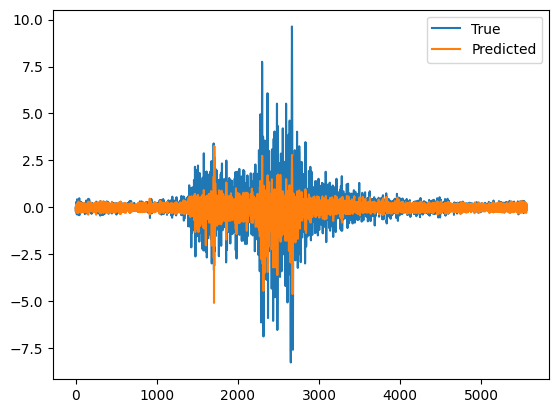

In [173]:
plt.plot(test_y.cpu().numpy(), label='True')
plt.plot(test_outputs.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [182]:
train_loss = pd.DataFrame(train_losses)
train_loss.columns = ['File', 'Loss']
avg_val_losses = pd.DataFrame(avg_val_losses)
avg_val_losses.columns = ['File', 'Loss']

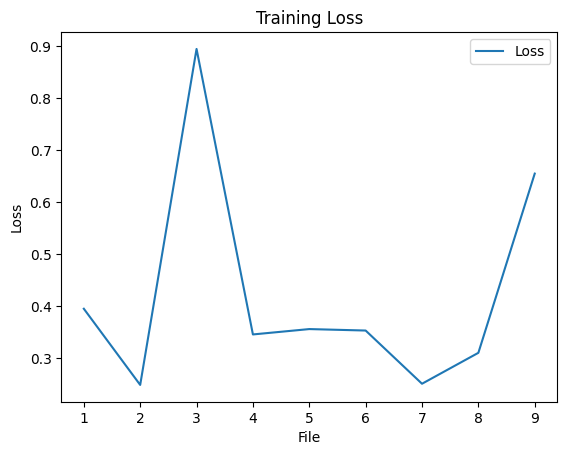

In [183]:
train_loss.plot(x='File', y='Loss')
plt.title('Training Loss')
plt.xlabel('File')
plt.ylabel('Loss')
plt.show()

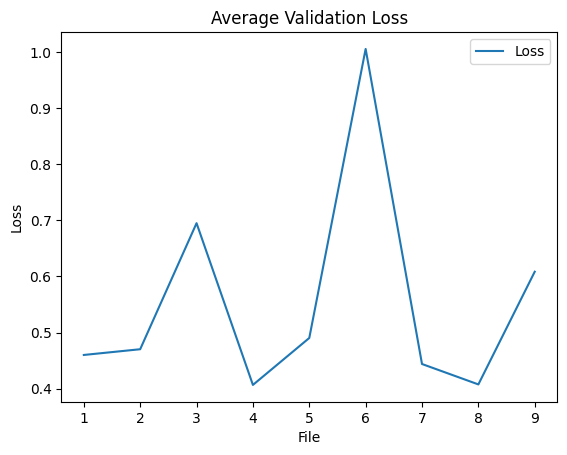

In [184]:
avg_val_losses.plot(x='File', y='Loss')
plt.title('Average Validation Loss')
plt.xlabel('File')
plt.ylabel('Loss')
plt.show()

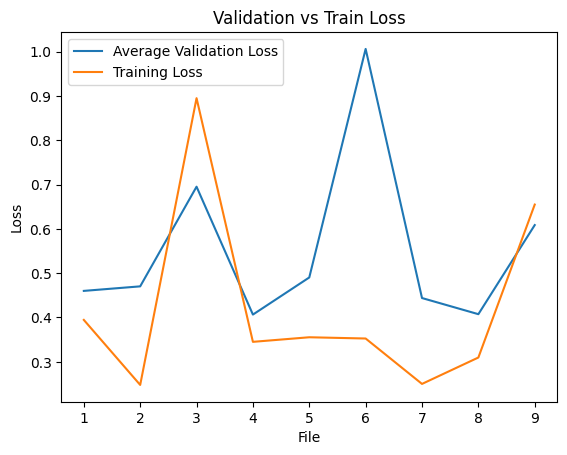

In [188]:
plt.plot(avg_val_losses['File'],avg_val_losses['Loss'], label='Average Validation Loss')
plt.plot(train_loss['File'],train_loss['Loss'] ,label='Training Loss')
plt.title('Validation vs Train Loss')
plt.xlabel('File')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [192]:
test_output_np = test_outputs.numpy()
test_y_np = test_y.numpy()

file_path = "results.txt"


header = "Predicted Values\tTrue Values"

combined_data = np.column_stack((test_output_np, test_y_np))


np.savetxt(file_path, combined_data, fmt='%f', delimiter='\t', header=header, comments='')



* Device Selection: If available we select gpu for parallel work else classic cpu, 51 gb ram provided.
* Model Initialization: We initialize a standart LSTM model with 100 size and 2 layers with dropout.
* Loss Function and Optimizer: As loss we use MSE, and for optimization Adam at training
* Training Loop: Iterates over each text file in the training set. For each file:
* * 1) First we load and process the data
* * 2) Split the data into i/o pair.
* * 3) We create PyTorch Dataset and dataloaders for training
* * 4) We load the previous weight if available for run.
* * 5) We execute the training for batch size 1, stochastic gradient descent for prevention of local minima fit, and to a 20 epochs and print loss.
* Validation: After each file scan we validate our training at validation sets.
* Average Validation Loss: We save the average validation loss from different validation sets.
* Model Saving: Save the last model to use it in the future (could also use best model approach too.)
* Return: We return the model, then the test data and test labels, also the train losses and validation losses for each file.

From results we see that we didn't overfit to the data since Test Loss: 0.6188 and Train Loss at last level is Train Loss: 0.6548 and Validation loss at Average Validation Loss: 0.6085.


* We could have selected the best training loss as our best model and save it, but I didn't do it to see whether it will fit better at the end, but it didnt. Normally, our training loss decreased to 0.3, and validation to 0.4 levels which is a little bit over fit, so we could still select something at 0.4 to 0.4 for a better model. (Its simple to do just save the prior train loss at the 20th epoch and check whether the next one is better or equal like best_train_loss > train_loss then best_train_loss = train_loss) and save that weight.

* The model didn't converge, but I do believe still shows the pattern, when there is a peak or not, but I am not an earthquake expert so cannot comment on that.

For difficulties:
*  I couldn't understand what is 10 sample as asked in the homework so I gave one of the datasets as test and made predicted and real outputs of it, probably more than 10 data, but I couldn't understand so just brought the result.

* I didn't understand whether we should use all the txt files or just one, I used all and separated them into different tasks.

* Files had record times but they were from different stations so I assumed data is sequential and it is for the same earthquake, so I disregarded the timestamp they had.

OVERALL:
* Model didn't overfit as it can be seen from the loss scores of MSE criterion, and I do believe since it is something like fully autoregressive 0.6 ish loss on MSE is acceptable/good.

* It was a great experience to experiment on earthquake data, learned that it is hard to model and predict the full pattern. Probably due to it is a dynamical problem with many confounding variables that has some effect to it.

* From the predicted, true plot I can still argue that if what we want to see is a motion pattern, amplitudes may be different, but it still catches the motion pattern, but not the amplitudes, so it may work to some extend.